# Pairwise Spectral EMD Example

Example code to load in events and calculate their pairwise spectral EMDs. Takes about 15 seconds to compile + 30 seconds to run on my laptop, assuming the dataset is already downloaded (Approx 11000 pairs per minute) uing the default presets in this notebook. The more memory, the merrier.

Before using, make sure to `pip install .` in the root directory of this repository.

In [1]:
from pyspecter.SPECTER import SPECTER

# Utils
from pyspecter.utils.data_utils import load_cmsopendata, load_triangles
from pyspecter.utils.plot_utils import initialize, newplot
initialize()


# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import time

# Load Dataset

In [2]:
# CMS Open Sim Parameters
pt_lower = 475
pt_upper = 525
eta_cut = 1.9
quality = 2
pad = 75 # Note that runtime is pad^2, memory is pad^4

n_samples = 100
batch_size = 250 # Number of pairs to process in parallel, can probably be increased.

# Load data -- this will take a while the first time. Downloads the data from the CMS Open Data portal. Sub in your own data if you have if you want.
dataset, sim_weights, k_factors = load_cmsopendata("~/.energyflow/", "sim", pt_lower, pt_upper, eta_cut, quality, pad = pad, n = n_samples, )
weights = sim_weights * k_factors



Max # of particles: 113


# Set up SPECTER

In [3]:
# Set up and compile SPECTER
specter = SPECTER(compile = True)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compiling SPECTER model...
Generating test events for tracing ...
Test events generated! Time taken:  1.5768897533416748  seconds.
Compiling observables...
Observables compiled! Time taken:  1.576944351196289  seconds.
Compiling spectral representation functions ...
Compilation complete! Time taken:  14.637939453125  seconds.


# Compute EMDs
Compute the EMDs between every pair of events, in parallel batches of `batch_size` events.

In [4]:
# Get list of pairwise indices
i_pairs, j_pairs = np.triu_indices(n_samples, k = 1)

# Initialize matrix to store pairwise EMDs
pairwise_emds = np.zeros((n_samples, n_samples))

# Compute batches
start_time = time.time()
for n in range(0, len(i_pairs), batch_size):

    print(f"Computing Batch {n}-{n+batch_size} of {len(i_pairs)} pairs. Elapsed Time: {time.time() - start_time :.3f} seconds")
    i_batch = i_pairs[n : n + batch_size]
    j_batch = j_pairs[n : n + batch_size]
    
    # Compute the pairwise EMDs
    emds = specter.spectralEMD(dataset[i_batch], dataset[j_batch])
    
    # Store the results
    pairwise_emds[i_batch, j_batch] = emds
    pairwise_emds[j_batch, i_batch] = emds

print(f"Done! Total Elapsed Time: {time.time() - start_time :.3f} seconds")

Computing Batch 0-250 of 4950 pairs. Elapsed Time: 0.000 seconds
Computing Batch 250-500 of 4950 pairs. Elapsed Time: 3.161 seconds
Computing Batch 500-750 of 4950 pairs. Elapsed Time: 4.573 seconds
Computing Batch 750-1000 of 4950 pairs. Elapsed Time: 5.977 seconds
Computing Batch 1000-1250 of 4950 pairs. Elapsed Time: 7.415 seconds
Computing Batch 1250-1500 of 4950 pairs. Elapsed Time: 8.900 seconds
Computing Batch 1500-1750 of 4950 pairs. Elapsed Time: 10.316 seconds
Computing Batch 1750-2000 of 4950 pairs. Elapsed Time: 11.741 seconds
Computing Batch 2000-2250 of 4950 pairs. Elapsed Time: 13.099 seconds
Computing Batch 2250-2500 of 4950 pairs. Elapsed Time: 14.466 seconds
Computing Batch 2500-2750 of 4950 pairs. Elapsed Time: 15.906 seconds
Computing Batch 2750-3000 of 4950 pairs. Elapsed Time: 17.347 seconds
Computing Batch 3000-3250 of 4950 pairs. Elapsed Time: 18.829 seconds
Computing Batch 3250-3500 of 4950 pairs. Elapsed Time: 20.268 seconds
Computing Batch 3500-3750 of 4950 p

Text(0, 0.5, 'Density')

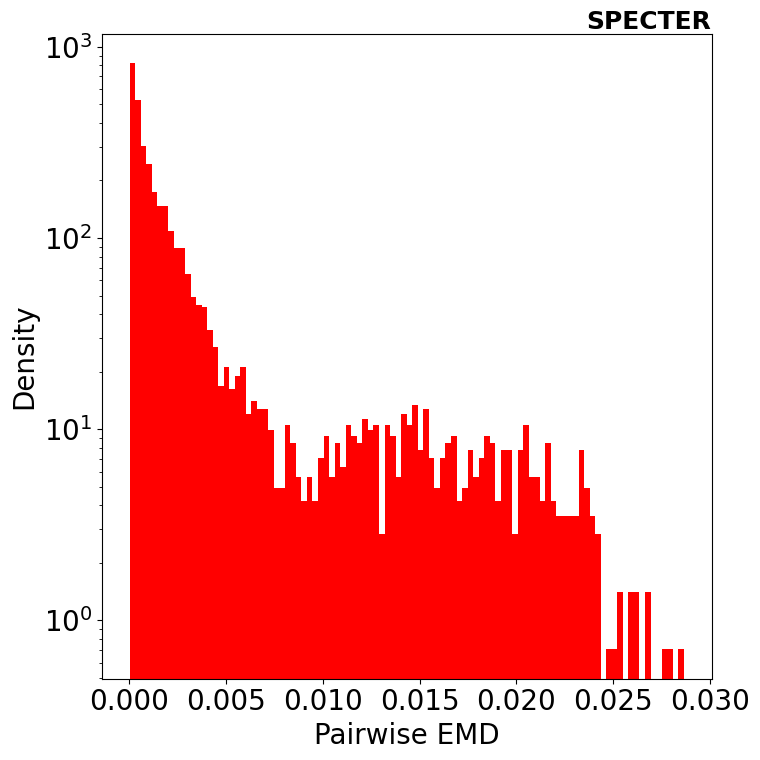

In [7]:
# Histogram the results (upper triangle only)
newplot()
plt.hist(pairwise_emds[np.triu_indices(n_samples, k = 1)], bins = 100, density=True)
plt.yscale("log")
plt.xlabel("Pairwise EMD")
plt.ylabel("Density")
